# Magics 4.12.0 ( Release May 2022)

Nice new features have been implemended in the version: have a look at the notebook to discover them. 

- EPSG:3035 projection  
- Automatic adjustement of the projection according to the data extend 
- Automatic selection of the best suited projection according to the data extend 
- Introduction of a new way to work with palette of colour lists. 
- Thinning of the wind when using NetCDF data.


In [1]:
from Magics import macro as magics
import ipywidgets as widgets
from ipywidgets import interact


## Implementation of EPSG:3035

This projection is well suited to display meteorological over Europe.


**EPSG reference:**  [ETRS89-extended / LAEA Europe](https://epsg.io/3035)

**Proj code:** *+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs*  

**Projected bounds:**  
1896628.62 1507846.05  
4662111.45 6829874.45  

**WGS84 bounds:**   
-16.1 32.88  
40.18 84.17  

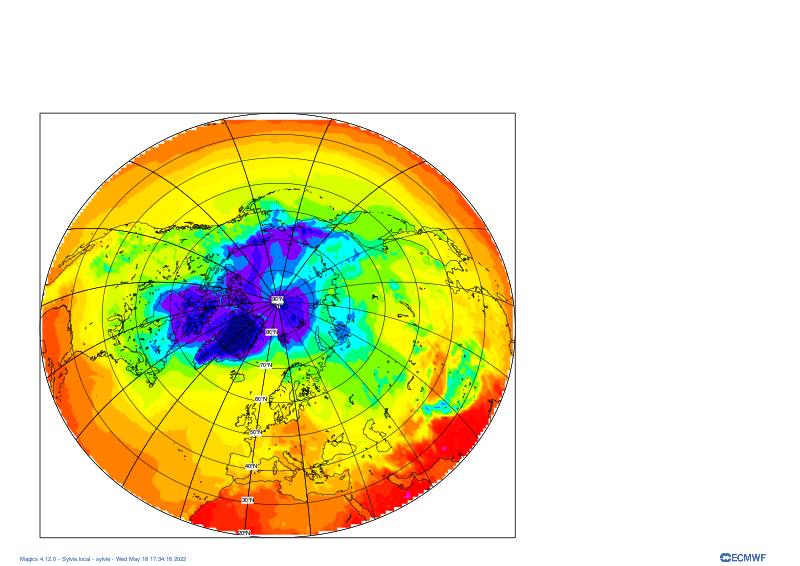

In [2]:
map = magics.mmap(
    subpage_map_projection = 'EPSG:3035',
)

data = magics.mgrib(grib_input_file_name = "data/2t.grib")

contour = magics.mcont(contour_automatic_setting="ecmwf")

coast = magics.mcoast(
    map_coastline_resolution="medium",
)

magics.plot(map, data, contour, coast)


## With a zoom over Europe 

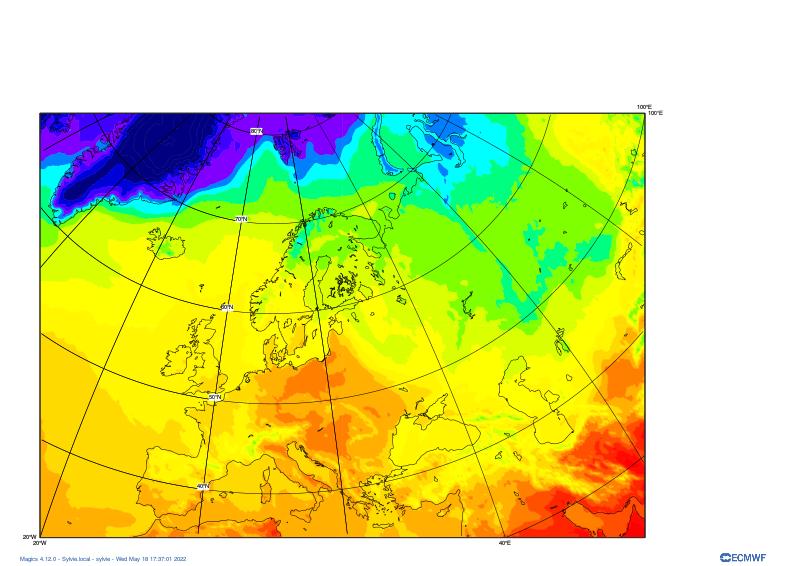

In [2]:
map = magics.mmap(
    subpage_map_projection = 'EPSG:3035',
    subpage_lower_left_longitude = -20.,
    subpage_lower_left_latitude = 30., 
    subpage_upper_right_longitude = 100.,
    subpage_upper_right_latitude = 50.,
    subpage_map_area_definition = 'corners'
    
)

data = magics.mgrib(grib_input_file_name = "data/2t.grib")
contour = magics.mcont(contour_automatic_setting="ecmwf")

coast = magics.mcoast(
    map_coastline_resolution="medium",
)

magics.plot(map, data, contour, coast)


# Automatic selection of the best suited projection according to the data extend

The use of the keyword **automatic** for the parameter **subpage_map_projection** will make magics decide of the best projection to use according to the data extend.   
The next cell demonstrates this possibility.   
We are waiting for your comments to improve our algorythm of selection. 

Here are the rules we apply:
- polar sterographic north if the minimum latitude is over 45 °, and rotating the vertical longitude.
- polar sterographic south if the minimum latitude is below -45 °and rotating the vertical longitude.
- cylindrical in the other cases, of if no data are provided


In [3]:
import glob 

files = glob.glob("data/*.grib")
files.append("No data")

In [7]:

@interact(file=widgets.Dropdown(options= files))
def automatic_projection(file):
    map = magics.mmap(
        subpage_map_projection = 'automatic',
    )
    coast = magics.mcoast(
        map_coastline_resolution="medium",
    )
    if ( file == "No data"):
        return magics.plot(map, coast)
    
    data = magics.mgrib(grib_input_file_name = file)
    contour = magics.mcont(contour_automatic_setting="ecmwf")

    coast = magics.mcoast(
        map_coastline_resolution="medium",
    )

    return magics.plot(map, data, contour, coast)

interactive(children=(Dropdown(description='file', options=('data/2t-automatic.grib', 'data/2t.grib', 'data/2t…

## When 2 fields are given, magics will use the max extend. 

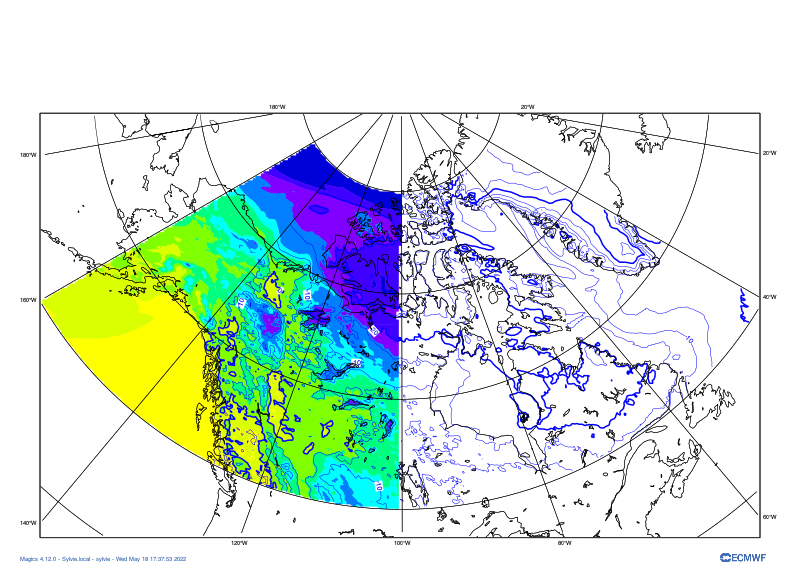

In [9]:
map = magics.mmap(
        subpage_map_projection = 'automatic',
    )
data1 = magics.mgrib(grib_input_file_name = "data/2t-automatic-polar-states2.grib")
data2 = magics.mgrib(grib_input_file_name = "data/2t-automatic-polar-states.grib")
magics.plot(map, data2, contour, data1, magics.mcont(), coast)

# Selection of the area according to the extend of the data, but using the user defined projection

This new mode is only avalaible for a subset of projections.   
Please contact the MagicsTeam, if you need another one. 

In [10]:

@interact(projection=widgets.Dropdown(options= [ "EPSG:4326", "EPSG:3035", 
                                                "EPSG:32661","EPSG:32761",
                                                "polar_north", "polar_south", 
                                                "automatic",]),
         file = widgets.Dropdown(options= files,))
def plot(projection, file) :
    area = magics.mmap(subpage_map_projection = projection,
                   subpage_map_area_definition = "data"
                      ) 
    # where area_name specifies the predefined area to select.
    data = magics.mgrib(grib_input_file_name = file)
    contour = magics.mcont(contour_automatic_setting="ecmwf")
    return magics.plot(area, data, contour, magics.mcoast())

interactive(children=(Dropdown(description='projection', options=('EPSG:4326', 'EPSG:3035', 'EPSG:32661', 'EPS…

# Plotting polar wind from a NetCDF file

In this version only the oceanographic convention is used.   
The next step will be to read this informattion from the parameter attributes.
The only implemented thinning is the data one.

**Rappel:**  
***Oceanographic convention:***   
Wind angles are clockwise (CW) from North. A wind angle of 0◦ denotes a wind flowing from the South to the North and 90◦ denotes a wind flowing from West to East  
***Meteorological convention:***   
Directions are measured clockwise (CW) from North. An angle of 0◦ denotes a Northerly wind flowing from North to South. An angle of 270◦ denotes a Westerly wind flowing from West to East.


In [25]:

@interact(thin_factor=widgets.IntSlider(min=1, max=200, step=1, value=50) )

def wind(thin_factor) :
   
    area = magics.mmap( 
    subpage_lower_left_longitude = 0.,
    subpage_lower_left_latitude = -90, 
    subpage_upper_right_longitude = 180.,
    subpage_upper_right_latitude = 90.,
    subpage_map_area_definition = 'corners')

    data = magics.mnetcdf(
               netcdf_filename = "polar-wind.nc",
               netcdf_type = "geopolarmatrix",
               netcdf_latitude_variable = "lat",
               netcdf_longitude_variable = "lon",
               netcdf_speed_component_variable = "wind_speed",
               netcdf_direction_component_variable = "wind_dir"
              )
    wind = magics.mwind(wind_thinning_method="data", 
                        wind_thinning_factor= thin_factor)

    coastlines = magics.mcoast()

    return  magics.plot(area, data, wind, coastlines)

interactive(children=(IntSlider(value=50, description='thin_factor', max=200, min=1), Output()), _dom_classes=…

# Introduction of a new mode for palette and colour_list

To simplify the definition of colours, we have created a dynamic policy to handle mistmatch between the number of colours provided and the number of colours needed.  
The dynamic policy will either create the missing colours, if not enough colours have been provided, or sample them.   
*contour_shade_colour_list_policy = dynamic* can be used for *contour_shade_colour_method = list or palette*
The next cell will demonstrate the differrent options 

In [12]:
import json
from Magics import macro as magics

import ipywidgets as widgets
from ipywidgets import interact

palettes = "palettes.json"

with open(palettes, "r") as f:
    data = json.load(f)

palettes = list(data.keys())

In [13]:



style = {'description_width': 'initial', 'width': 'max-content'}
@interact(
      contour_level_selection_type = widgets.Dropdown(description='contour_level_selection_type', options = ["count", "interval"], value='count', style=style),
      contour_interval= widgets.FloatSlider(description="contour_interval",  min= 0.1, default=1, max = 10, value=0.5, style=style),
      contour_level_count= widgets.IntSlider(description="contour_level_count",  min= 2, default=10, max =50, value=10, style=style),
      contour_shade_colour_method = widgets.Dropdown(description='contour_shade_colour_method', options = ["list", "palette"], value='palette', style=style),
      contour_shade_palette_name=widgets.Dropdown(description='contour_shade_palette_name', options = palettes, value ="ecmwf", style=style), 
      contour_shade_colour_list = widgets.Text( description='contour_shade_colour_list', value='red/green/yellow/blue', style=style),
      contour_shade_colour_list_policy = widgets.Dropdown(description='contour_shade_colour_list_policy', options = ["lastone", "cycle", "dynamic"], value ="dynamic", style=style),
      contour_shade_colour_reverse_list = widgets.ToggleButtons(description='contour_shade_colour_reverse_list',options=['on', 'off'],value="off", style=style)
         )

def plot(contour_level_selection_type, contour_interval, contour_level_count, contour_shade_colour_method, 
         contour_shade_palette_name, contour_shade_colour_list, 
         contour_shade_colour_list_policy, contour_shade_colour_reverse_list) :
    
    area = magics.mmap(subpage_map_projection = "polar_north",
                   subpage_expand_mode = True,
                   subpage_map_area_definition = "data") 
    # where area_name specifies the predefined area to select.
    data = magics.mgrib(grib_input_file_name = "data/2t-automatic-polar-east.grib")
    #Defining the contour
    
   
    contour = magics.mcont(
        legend                       = 'on',
        contour                      = 'off',
        contour_shade                = 'on',
        contour_label                = 'off',
        contour_level_selection_type = contour_level_selection_type,
        contour_level_count =  contour_level_count,
        contour_interval             = contour_interval,
        contour_level_tolerance      = 0,
        contour_shade_method         = 'area_fill',
        contour_shade_palette_name   = contour_shade_palette_name,
        contour_shade_colour_list = contour_shade_colour_list.split("/"),
        contour_shade_colour_list_policy = contour_shade_colour_list_policy,
        contour_shade_colour_reverse_list = contour_shade_colour_reverse_list,
        contour_shade_colour_method  = contour_shade_colour_method,
        
    
        
    )
    
    

    coast = magics.mcoast(
        map_coastline_resolution="medium",
    )
    
    legend = magics.mlegend(
        legend_label_frequency = 10,
        legend_display_type        = "continuous",
        legend_box_mode            = "automatic",
        legend_automatic_position  = "top",
        legend_text_font_size      = "0.50",
        legend_text_colour         = "ecmwf_blue",    
        legend_entry_border        = "on",
        legend_entry_border_colour = "none") 

    
    return magics.plot(area, data, contour, coast, legend)




interactive(children=(Dropdown(description='contour_level_selection_type', options=('count', 'interval'), styl…

# Examples of use 

Working with rainbow and advanced symbol plotting.


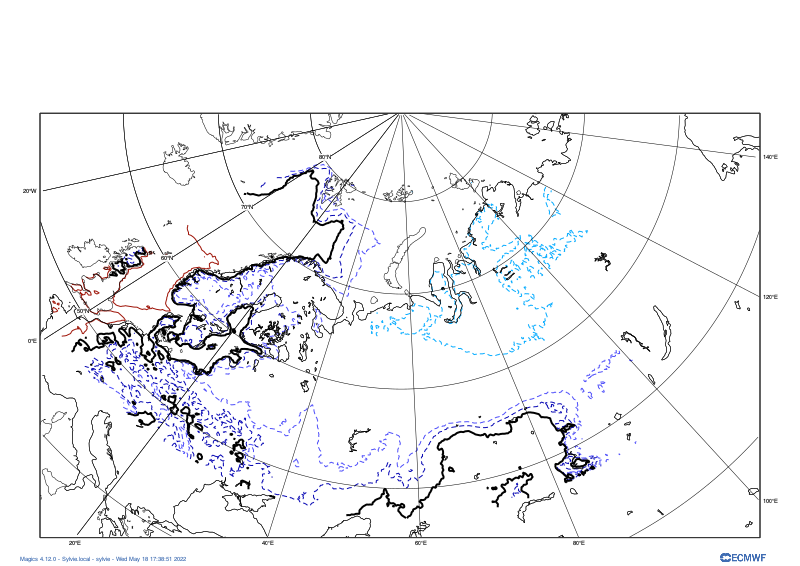

In [14]:
from Magics import macro as magics

area = magics.mmap(subpage_map_projection = "polar_north",
               subpage_expand_mode = True,
               subpage_map_area_definition = "data") 
# where area_name specifies the predefined area to select.
data = magics.mgrib(grib_input_file_name = "data/2t-automatic-polar-east.grib")
#Defining the contour


split = magics.mcont(
    contour_label="off",
    contour_threads=1, # to avoid differences in dashed lines
    contour_line_thickness=2,
    contour_line_colour_rainbow="on",
    contour_line_colour_rainbow_method="list",
    contour_line_colour_rainbow_colour_list=[
    "RGB(0.02,0.67,1)",
    "RGB(0.31,0.31,0.98)",
    "RGB(0.024,0.024,0.7)",
    "BLACK",
    "RGB(0.62,0.077,0.028)",
    "RGB(0.77,0.019,0.019)",
    "RED",
    ],
    contour_line_thickness_rainbow_list=[2, 2, 2, 4, 2, 2, 2],
    contour_line_style_rainbow_list=[
    "dash",
    "dash",
    "dash",
    "solid",
    "solid",
    "solid",
    "solid",
    ],
    contour_highlight="off",
    contour_level_selection_type="level_list",
    contour_interval = 2,
    contour_level_list=[-30, -5, -2, 0, 5, 10, 30],
)



coast = magics.mcoast(
    map_coastline_resolution="medium",
)

legend = magics.mlegend(
    legend_label_frequency = 10,
    legend_display_type        = "continuous",
    legend_box_mode            = "automatic",
    legend_automatic_position  = "top",
    legend_text_font_size      = "0.50",
    legend_text_colour         = "ecmwf_blue",    
    legend_entry_border        = "on",
    legend_entry_border_colour = "none") 


magics.plot(area, data, split, coast, legend)


In [26]:
import random

lat = random.sample(range(-90, 90), 30)
lon = random.sample(range(-180, 180), 30)
values = random.sample(range(-20, 20), 30)

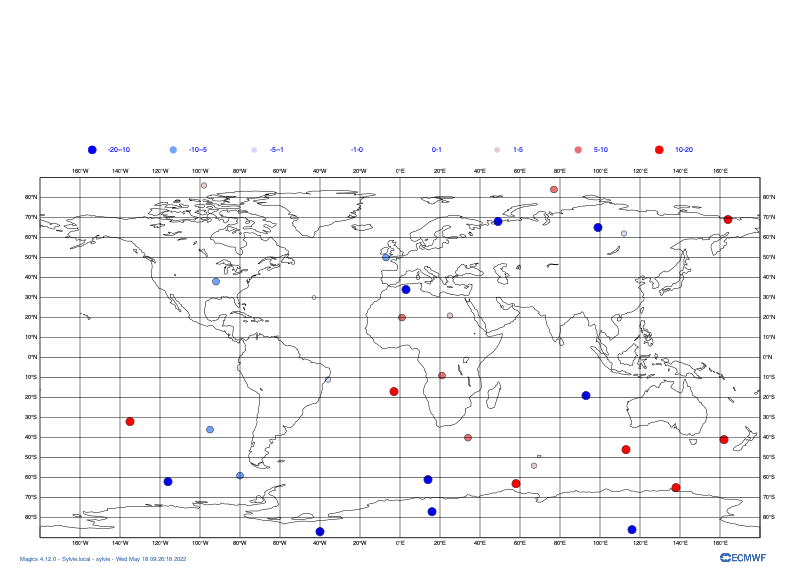

In [27]:
data = magics.minput(
    input_longitude_values = lon,
	input_latitude_values = lat,
    input_values = values,
)
    

diff_symb = magics.msymb(
    legend="on",
    symbol_type="marker",
    symbol_table_mode="advanced",
    symbol_outline="on",
    symbol_outline_colour="charcoal",
    symbol_advanced_table_selection_type="list",
    symbol_advanced_table_level_list=[
    -20,
    -10,
    -5,
    -1,
    0,
    1,
    5,
    10,
    20,
    ],
    symbol_advanced_table_colour_method="list",
    symbol_advanced_table_colour_list=[
    "blue",
    "sky",
    "rgb(0.82,0.85,1)",
    "white",
    "white",
    "rgb(0.9,0.8,0.8)",
    "rgb(0.9,0.45,0.45)",
    "red",
    ],
    symbol_advanced_table_height_list=[0.6, 0.5, 0.4, 0.3, 0.3, 0.4, 0.5, 0.6],
)

magics.plot(data, data, diff_symb, magics.mcoast())

# Coming on 4.13.0

- Adjustement of the symbol height according to the projection extend. (symbol size will increase when zooming) 
- Wind components defined in 2 grib files. ( up to now they need to be in the same grib file)
- Introduction of an **out_of_bound** concept when user is giving a list of levels. (*contour_level_selection_type='list'*)
    - *contour_out_of_bound_min/contour_out_of_bound_min_colour* -> colour to use for the min range + legend in triangle
    - *contour_out_of_bound_max/contour_out_of_bound_max_colour* -> colour to use for the max range. + legend in triangle
